In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error
import xgboost as xgb

import math

In [2]:
df = pd.read_csv('Sport car price (1).csv')
df.head()

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,Porsche,911,2022,3,379,331,4,"101,200"
1,Lamborghini,Huracan,2021,5.2,630,443,2.8,"274,390"
2,Ferrari,488 GTB,2022,3.9,661,561,3,"333,750"
3,Audi,R8,2022,5.2,562,406,3.2,"142,700"
4,McLaren,720S,2021,4,710,568,2.7,"298,000"


In [3]:
df.shape

(1007, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Car Make                 1007 non-null   object
 1   Car Model                1007 non-null   object
 2   Year                     1007 non-null   int64 
 3   Engine Size (L)          997 non-null    object
 4   Horsepower               1007 non-null   object
 5   Torque (lb-ft)           1004 non-null   object
 6   0-60 MPH Time (seconds)  1007 non-null   object
 7   Price (in USD)           1007 non-null   object
dtypes: int64(1), object(7)
memory usage: 63.1+ KB


In [5]:
# Checking the percentage of missing values across all the columns
null = pd.DataFrame({'Null Values':df.isnull().sum(),'Percentage Null Values':df.isnull().sum()*100/len(df)})
null

,Null Values,Percentage Null Values
Car Make,0,0.000000
Car Model,0,0.000000
Year,0,0.000000
Engine Size (L),10,0.993049
Horsepower,0,0.000000
Torque (lb-ft),3,0.297915
0-60 MPH Time (seconds),0,0.000000
Price (in USD),0,0.000000


In [6]:
# now i am dropping all missing values
df.dropna(inplace = True)

Data Preparing
For 'Price' column, we will just replace ',' by nothing and convert type to integer.
For 'Engine Size (L)' column, in the original data, there are all categorical data and contains data like 'Electric' or 'Electric Motor', etc. It's difficult for the analysis with the column that contains both numerical and categorical data. So we will create a new column 'Engine Size Cat' with 'Small', 'Medium','Large','Extra Large' categories, the ruls are as below:

->'Small' --> '0'-'2'

->'Medium' --> '2'-'4'

->'Large'--> '4'-'6'

->'Extra Large'-->'6'-'8'

and the other type of Engine Size, we will take the same value in the column of 'Engine Size (L)'

For 'Horsepower' column, we will replace ',' and '+' by nothing and convert the type to integer.
For 'Torque (lb-ft)' column, we will replace ',', '-' and '+' by nothing and convert the type to integer.
For '0-60 MPH Time (seconds)' column, we will replace '< 1.9' by '1.0' and convert type to float.

In [7]:
# target Price column
df['Price (in USD)'] = df['Price (in USD)'].apply(lambda x:str(x).replace(',','')).astype(int)

# Engine Size (L) column
# create new column 'c' to convert only numerical variables
df['c'] = df['Engine Size (L)'].str.extract(r'^(\d+\.?\d*)$').astype(float)
# set bins and values 
bins = [-1e5,2,4,6,8,10]
values = ['Extra Small','Small', 'Medium', 'Large', 'Extra Large']
# create new column 'Engine Size Cat' and convert type like string. pd.cut return categorical type.
df['Engine Size Cat'] = pd.cut(df['c'],bins,labels=values).astype('string')
# if Engine Size Cat value is equals to nan, put the Engine Size (L) corresponds value.
df.loc[df['Engine Size Cat'].isna(),'Engine Size Cat'] = df.loc[df['Engine Size Cat'].isna(),'Engine Size (L)']
# remove 'Engine Size (L)' and 'c' columns
df.drop(['Engine Size (L)','c'],axis=1,inplace=True)

# Horsepower column
df['Horsepower'] = df['Horsepower'].apply(lambda x:str(x).replace(',','').replace('+','')).astype(int)

# Torque (lb-ft) column
df['Torque (lb-ft)'] = df['Torque (lb-ft)'].apply(lambda x:str(x).replace(',','').replace('+','').replace('-','0')).astype(int)

# 0-60 MPH Time (seconds) column
df['0-60 MPH Time (seconds)'] = df['0-60 MPH Time (seconds)'].apply(lambda x:str(x).replace('< 1.9','1.0')).astype(float)

# Create a new column Car Age
df['Car Age'] = 2023 - df['Year']
df.drop('Year',axis=1,inplace=True)

In [8]:
df.describe()

,Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD),Car Age
count,995.000000,995.000000,995.000000,9.950000e+02,995.000000
mean,633.239196,554.325628,3.527910,3.754200e+05,1.804020
std,415.713337,437.535222,0.769341,7.304419e+05,2.030646
min,181.000000,0.000000,1.000000,2.500000e+04,0.000000
25%,454.000000,406.000000,2.900000,7.180000e+04,1.000000
50%,591.000000,509.000000,3.500000,1.350000e+05,2.000000
75%,671.000000,602.000000,4.000000,2.490000e+05,2.000000
max,10000.000000,10000.000000,6.500000,5.200000e+06,58.000000


In [10]:
# From the statistics number above, we can see some outliers in 'Torque (lb-ft)' column, so we will exclude the data which 'Torque (lb-ft)' equals to 0.
df = df[df['Torque (lb-ft)']!=0]

# Target variable - Price

<AxesSubplot: xlabel='Price (in USD)', ylabel='Density'>

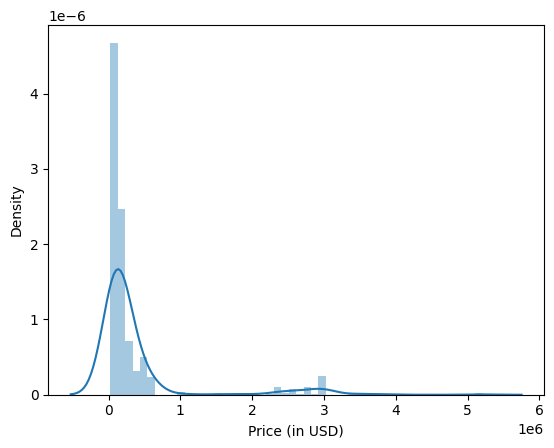

In [11]:
sns.distplot(df['Price (in USD)'])

# Univariate Analysis

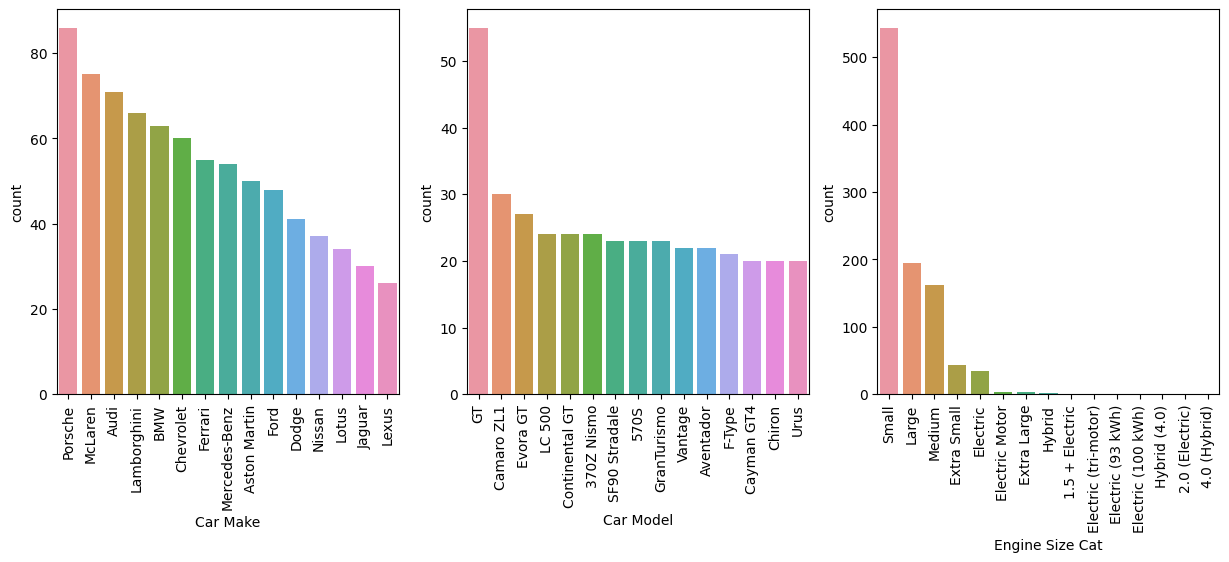

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
car_make = df['Car Make'].value_counts().head(15).reset_index()
car_make.columns = ['Car Make','count']
sns.barplot(data=car_make,x='Car Make',y='count')
plt.xticks(rotation=90)

plt.subplot(1,3,2)
car_model = df['Car Model'].value_counts().head(15).reset_index()
car_model.columns = ['Car Model','count']
sns.barplot(data=car_model,x='Car Model',y='count')
plt.xticks(rotation=90)

plt.subplot(1,3,3)
engine = df['Engine Size Cat'].value_counts().head(15).reset_index()
engine.columns = ['Engine Size Cat','count']
sns.barplot(data=engine,x='Engine Size Cat',y='count')
plt.xticks(rotation=90)
plt.show()

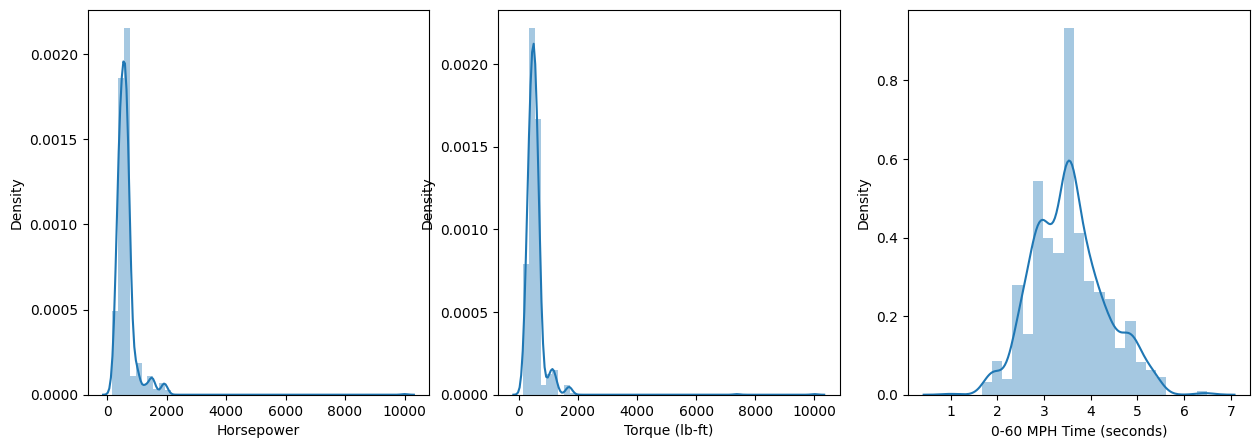

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.distplot(df['Horsepower'])

plt.subplot(1,3,2)
sns.distplot(df['Torque (lb-ft)'])

plt.subplot(1,3,3)
sns.distplot(df['0-60 MPH Time (seconds)'])
plt.show()

# Bivariate Analysis

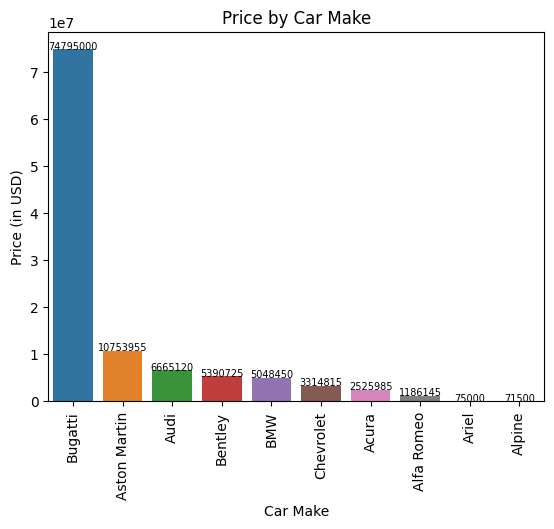

In [14]:
car_make_sum = df.groupby('Car Make')['Price (in USD)'].sum().reset_index().head(10).sort_values('Price (in USD)',ascending=False).reset_index(drop=True)
g = sns.barplot(data=car_make_sum,x='Car Make',y='Price (in USD)')
for v in car_make_sum.itertuples():
    #print(v._2)
    g.text(x=v.Index,y=v._2,s=str(round(v._2, 2)), size=7, ha="center")
plt.title('Price by Car Make')
plt.xticks(rotation=90)
plt.show()

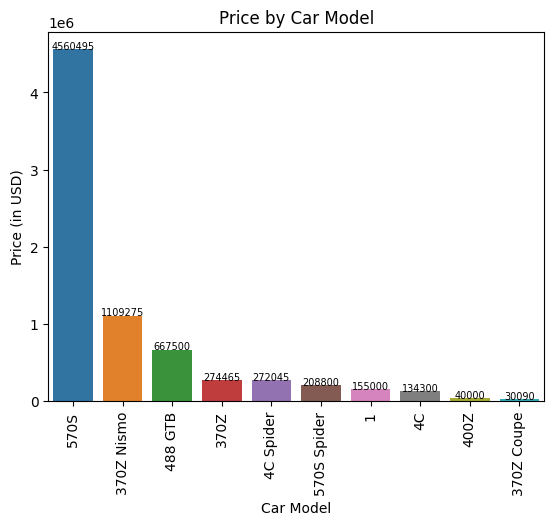

In [15]:
car_model_sum = df.groupby('Car Model')['Price (in USD)'].sum().reset_index().head(10).sort_values('Price (in USD)',ascending=False).reset_index(drop=True)
g = sns.barplot(data=car_model_sum,x='Car Model',y='Price (in USD)')
for v in car_model_sum.itertuples():
    #print(v._2)
    g.text(x=v.Index,y=v._2,s=str(round(v._2, 2)), size=7, ha="center")
plt.title('Price by Car Model')
plt.xticks(rotation=90)
plt.show()

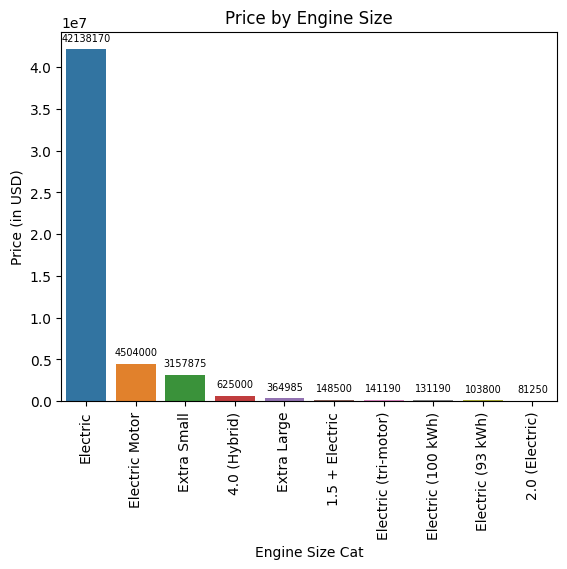

In [16]:
engine_sum = df.groupby('Engine Size Cat')['Price (in USD)'].sum().reset_index().head(10).sort_values('Price (in USD)',ascending=False).reset_index(drop=True)
g = sns.barplot(data=engine_sum,x='Engine Size Cat',y='Price (in USD)')
for v in engine_sum.itertuples():
    #print(v._2)
    g.text(x=v.Index,y=v._2+1e6,s=str(round(v._2, 2)), size=7, ha="center")
plt.title('Price by Engine Size')
plt.xticks(rotation=90)
plt.show()

# # # For 'Horsepower' column, we will sort value in ascending order, then create the differents ranges to convert it to a categorical variable for analysis.

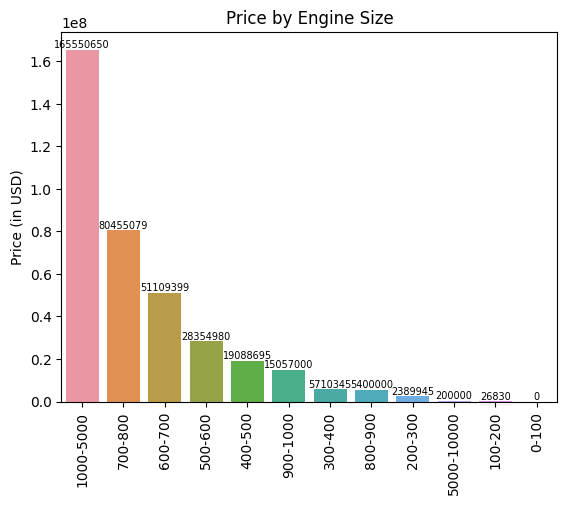

In [20]:
# Checking the number of unique Horsepower in ascending order
np.array(sorted(df.Horsepower.unique()))

# Bucketing the Horsepower across ranges to convert it to a categorical variable
df['Horsepower_bucket'] = pd.cut(df['Horsepower'],[0,100,200,300,400,500,600,700,800,900,1000,5000,10000],labels=['0-100','100-200','200-300','300-400','400-500','500-600','600-700','700-800','800-900','900-1000','1000-5000','5000-10000'])

# plot value
horsepower_bucket = df.groupby('Horsepower_bucket')['Price (in USD)'].sum().reset_index().sort_values('Price (in USD)',ascending=False,ignore_index=True)
g = sns.barplot(data=horsepower_bucket,x=horsepower_bucket.index,y='Price (in USD)')
for v in horsepower_bucket.itertuples():
    #print(v)
    g.text(x=v.Index,y=v._2+1e6,s=str(v._2), size=7, ha="center")
plt.title('Price by Engine Size')
plt.xticks(ticks=horsepower_bucket.index,labels=horsepower_bucket['Horsepower_bucket'].values,rotation=90)
plt.show()

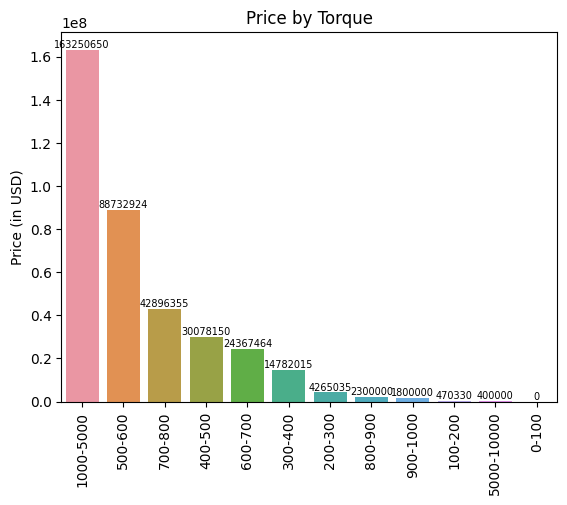

In [21]:
# same  with 'Torque' column
# Checking the number of unique Horsepower in ascending order
np.array(sorted(df['Torque (lb-ft)'].unique()))

# Bucketing the Horsepower across ranges to convert it to a categorical variable
df['Torque_bucket'] = pd.cut(df['Torque (lb-ft)'],[0,100,200,300,400,500,600,700,800,900,1000,5000,10000],labels=['0-100','100-200','200-300','300-400','400-500','500-600','600-700','700-800','800-900','900-1000','1000-5000','5000-10000'])

# plot value
torque_bucket = df.groupby('Torque_bucket')['Price (in USD)'].sum().reset_index().sort_values('Price (in USD)',ascending=False,ignore_index=True)
g = sns.barplot(data=torque_bucket,x=torque_bucket.index,y='Price (in USD)')
for v in torque_bucket.itertuples():
    #print(v)
    g.text(x=v.Index,y=v._2+1e6,s=str(v._2), size=7, ha="center")
plt.title('Price by Torque')
plt.xticks(ticks=torque_bucket.index,labels=torque_bucket['Torque_bucket'].values,rotation=90)
plt.show()

In [22]:
df.drop(['Horsepower_bucket','Torque_bucket'],axis=1,inplace=True)

# Data Preprocessing

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for c in df.columns:
    if (df[c].dtype == 'object') or (df[c].dtype == 'string'):
        df[c] = le.fit_transform(df[c])

In [24]:
X = df.drop('Price (in USD)',axis=1)
y = df['Price (in USD)']

In [25]:
# splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [26]:
# splitting the test set into further test and validation set
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,train_size=0.5,random_state=42)

# Model Building

In [27]:
# Creating an XGBRegression object with default paramters
xgb_reg = xgb.XGBRegressor(n_jobs = -1) # default paramters
xgb_reg.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [28]:
# Fitting the XGBRegression model on the train dataset
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [29]:
# Predicting on the test dataset
y_pred_test = xgb_reg.predict(X_test)
r2score = round(r2_score(y_pred_test,y_test),2)*100

In [30]:
# Calculating the R2 score on the test dataset
print("R2 Score on Test Data is : ",r2score)

R2 Score on Test Data is :  92.0


In [31]:
# Calculating Mean Sqaured Error & Root Mean Squared Error
mse = mean_squared_error(y_test, y_pred_test)
rmse = round(math.sqrt(mse),2)
print(rmse)

256572.83


# Random Search for Xgboost Regression

In [32]:
# Performing RandomizedSearchCV for hyperparameter tuning
params = {
        'n_estimators' : [100, 200, 500, 750], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

folds = 5
param_comb = 100

random_search = RandomizedSearchCV(xgb_reg, param_distributions=params, n_iter=param_comb, n_jobs=-1, cv=folds, verbose=3, random_state=42)

# Fitting on the validation set
random_search.fit(X_val, y_val)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=100, n_jobs=-1,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.1, 0.5, 1, 1.5, 5],
                                        'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.25],
                                        'max_depth': [3, 4, 5, 10, 12],
                                        'min_child_weight': [1, 5, 7, 10],
                                        'n_estimators': [100, 200, 500, 750],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, verbose=3)

In [33]:
# Printing the best score that we can get using the parameters
print('We can get score of :',random_search.best_score_,' using',random_search.best_params_)

We can get score of : 0.7216096343034591  using {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.02, 'gamma': 1, 'colsample_bytree': 0.8}


In [34]:
# Creating XGBRegression model with the select hyperparameters
xgb_reg_hpt = xgb.XGBRegressor(subsample=0.6, n_estimators=750, min_child_weight=1,max_depth=12,
                               learning_rate=0.25, gamma=1, colsample_bytree=0.6, n_jobs = -1)
xgb_reg_hpt.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 1,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.25,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 12,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 750,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.6,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [35]:
# Fitting the model on the train set
xgb_reg_hpt.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=750, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [36]:
# Predicting on the test set
y_pred_test_hpt = xgb_reg_hpt.predict(X_test)

# Calculating R2 score on test set
r2score = round(r2_score(y_pred_test_hpt,y_test),2)*100

In [37]:
# Printing the R2 score on test dataset
print("R2 score on Test Data is : ",r2score)

R2 score on Test Data is :  94.0


In [38]:
# Printing the R2 score on test dataset
print("R2 score on Test Data is : ",r2score)

R2 score on Test Data is :  94.0


In [39]:
# Calculating Mean Sqaured Error & Root Mean Squared Error of the test set
mse = mean_squared_error(y_test, y_pred_test_hpt)
rmse = round(math.sqrt(mse),2)
print(rmse)

214395.48


# Prediction and Model evaluation

In [40]:
# Calculating R2 score
y_train_pred = xgb_reg_hpt.predict(X_train)
y_test_pred = xgb_reg_hpt.predict(X_test)

r2_train_lr = r2_score(y_train, y_train_pred)
print("R2 score on Training data : ",round(r2_train_lr,2)*100)

r2_test_lr = r2_score(y_test, y_test_pred)
print("R2 score on Test data : ",round(r2_test_lr,2)*100)

R2 score on Training data :  100.0
R2 score on Test data :  94.0


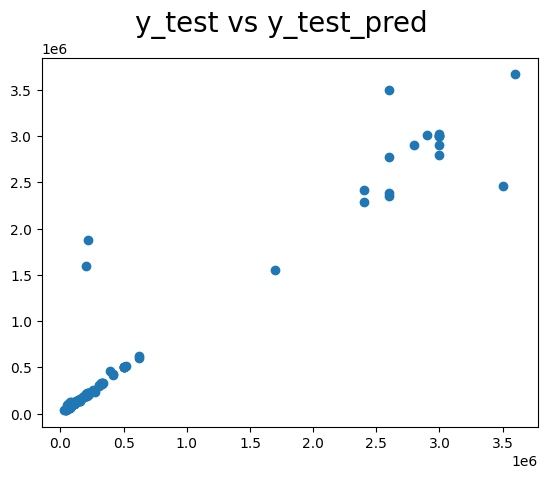

In [41]:
# Plotting a scatter plot of the actual and predicted values of the test set
fig = plt.figure()
fig.suptitle('y_test vs y_test_pred',fontsize=20)
plt.scatter(y_test,y_test_pred)

In [42]:
# Creating a dataframe containing the features names and its corresponding coefficient values
linear_model_parameter = list(abs(xgb_reg_hpt.feature_importances_))
cols = X_train.columns
lm_model_df = pd.DataFrame(list(zip(cols,linear_model_parameter)))
lm_model_df.columns = ['Feaure','Coef']

In [43]:
# Only selecting the features whose coeficient values are greater than 0
lm_model_df = lm_model_df[lm_model_df['Coef']>0]

In [44]:
# Sorted the created dataframe containing the features names and its corresponding coefficient values in descending order 
# inorder to get the top coefficients
lm_model_df.sort_values(by='Coef',ascending=False).reset_index(drop=True)

,Feaure,Coef
0,Torque (lb-ft),0.620520
1,Horsepower,0.213303
2,Car Model,0.045792
3,Car Make,0.038621
4,Engine Size Cat,0.036574
5,0-60 MPH Time (seconds),0.033994
6,Car Age,0.011195
